# Task 1
- Web scraping and analysis
This Jupyter notebook includes some code to get you started with web scraping. We will use a package called BeautifulSoup to collect the data from the web. Once you've collected your data and saved it into a local .csv file you should start with your analysis.

- Scraping data from Skytrax
If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use Python and BeautifulSoup to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [4]:
# Standard Libraries

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


# For Web Scrapping
import requests
from bs4 import BeautifulSoup

# For Data Pre-processing

import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer   
from textblob import Word, TextBlob
from wordcloud import WordCloud , STOPWORDS

# For topic modeling
from sklearn.decomposition import NMF, LatentDirichletAllocation



# Extracting reviews from "Skytrax" website

In [6]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 15
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews
Scraping page 11
   ---> 1100 total reviews
Scraping page 12
   ---> 1200 total reviews
Scraping page 13
   ---> 1300 total reviews
Scraping page 14
   ---> 1400 total reviews
Scraping page 15
   ---> 1500 total reviews


In [8]:
# Storing reviews in a pandas dataframe 
df = pd.DataFrame()               
df["reviews"] = reviews             
df.head(n=10)

,reviews
0,Not Verified | The WORST customer experience! ...
1,Not Verified | Had to cancel my flight month...
2,✅ Trip Verified | Flight cancelled with no rea...
3,✅ Trip Verified | This is a route I fly regula...
4,✅ Trip Verified | While BA may have made some...
5,✅ Trip Verified | British Airways new Club Sui...
6,"✅ Trip Verified | Four very pleasant, on time..."
7,Not Verified | We travel extensively over 25...
8,✅ Trip Verified | Flight delayed an hour due ...
9,✅ Trip Verified | A very full flight made Pre...


Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

# Text Preprocessing

Removing the parts before | in the reviews column

In [9]:
df.reviews= df.reviews.str.split('|',expand=True)[1]
df

,reviews
0,The WORST customer experience! British Airway...
1,Had to cancel my flight months in advance d...
2,Flight cancelled with no reason given less th...
3,This is a route I fly regularly. Used first c...
4,While BA may have made some positive improve...
...,...
1495,London Heathrow to Basel. Boarding: There ar...
1496,Miami to London Heathrow. A bit of a mixed b...
1497,Prague to Washington via London. British Air...
1498,Cape Town to London. I can report a positive...


# Rule-based approach

This is a practical approach to analyzing text without training or using machine learning models. The result of this approach is a set of rules based on which the text is labeled as positive/negative/neutral. These rules are also known as lexicons. Hence, the Rule-based approach is called Lexicon based approach.

Widely used lexicon-based approaches are TextBlob, VADER, SentiWordNet.

# Data preprocessing steps:

Cleaning the text

Tokenization

Enrichment – POS tagging

Stopwords removal

Obtaining the stem words

#  Cleaning the text

In [12]:
import re

# Define a function to clean the text
def clean(text):
# Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', str(text))
    return text

# Cleaning the text in the review column
df['Cleaned Reviews'] = df['reviews'].apply(clean)
df.head(n=10)

,reviews,Cleaned Reviews
0,The WORST customer experience! British Airway...,The WORST customer experience British Airways...
1,Had to cancel my flight months in advance d...,Had to cancel my flight months in advance due...
2,Flight cancelled with no reason given less th...,Flight cancelled with no reason given less th...
3,This is a route I fly regularly. Used first c...,This is a route I fly regularly Used first cl...
4,While BA may have made some positive improve...,While BA may have made some positive improvem...
5,British Airways new Club Suite is a marked im...,British Airways new Club Suite is a marked im...
6,"Four very pleasant, on time flights with fri...",Four very pleasant on time flights with frien...
7,We travel extensively over 25 years and ten...,We travel extensively over years and tend to ...
8,Flight delayed an hour due to bad weather ar...,Flight delayed an hour due to bad weather aro...
9,A very full flight made Premium Economy feel...,A very full flight made Premium Economy feel ...


# Step 2: Tokenization
Tokenization is the process of breaking the text into smaller pieces called Tokens. It can be performed at sentences(sentence tokenization) or word level(word tokenization).

# Step 3: Enrichment – POS tagging
Parts of Speech (POS) tagging is a process of converting each token into a tuple having the form (word, tag). POS tagging essential to preserve the context of the word and is essential for Lemmatization.

# Step 4: Stopwords removal
Stopwords in English are words that carry very little useful information. We need to remove them as part of text preprocessing. nltk has a list of stopwords of every language.

# Step 5: Obtaining the stem words
A stem is a part of a word responsible for its lexical meaning. The two popular techniques of obtaining the root/stem words are Stemming and Lemmatization.

The key difference is Stemming often gives some meaningless root words as it simply chops off some characters in the end. Lemmatization gives meaningful root words, however, it requires POS tags of the words.

NLTK is a leading platform for building Python programs to work with human language data. 

It provides easy-to-use interfaces to over 50 corpora and lexical resources such as WordNet, along 
with a suite of text processing libraries for classification, tokenization, stemming, tagging, 
parsing, and semantic reasoning, wrappers for industrial-strength NLP libraries

In [14]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet
"""This punkt tokenizer divides a text into a list of sentences by using an unsupervised algorithm to build a model for abbreviation words, 
collocations, and words that start sentences. """

#The nltk.corpus package defines a collection of corpus reader classes, which can be used to access the contents of a diverse set of corpora.


nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    #print(tags)
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
          newlist.append(tuple([word, pos_dict.get(tag[0])]))
          #print(tag[0])
          #print(pos_dict.get(tag[0]))
    return newlist 

df['POS tagged'] = df['Cleaned Reviews'].apply(token_stop_pos)
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\charl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\charl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\charl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\charl\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\charl\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,reviews,Cleaned Reviews,POS tagged
0,The WORST customer experience! British Airway...,The WORST customer experience British Airways...,"[(WORST, n), (customer, n), (experience, n), (..."
1,Had to cancel my flight months in advance d...,Had to cancel my flight months in advance due...,"[(cancel, v), (flight, n), (months, n), (advan..."
2,Flight cancelled with no reason given less th...,Flight cancelled with no reason given less th...,"[(Flight, n), (cancelled, v), (reason, n), (gi..."
3,This is a route I fly regularly. Used first c...,This is a route I fly regularly Used first cl...,"[(route, n), (fly, v), (regularly, r), (Used, ..."
4,While BA may have made some positive improve...,While BA may have made some positive improvem...,"[(BA, n), (may, None), (made, v), (positive, a..."


In [15]:
# Obtaining the stem words – Lemmatization

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
     if not pos:
        lemma = word
        lemma_rew = lemma_rew + " " + lemma
     else:
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

df['Lemma'] = df['POS tagged'].apply(lemmatize)
df.head()

,reviews,Cleaned Reviews,POS tagged,Lemma
0,The WORST customer experience! British Airway...,The WORST customer experience British Airways...,"[(WORST, n), (customer, n), (experience, n), (...",WORST customer experience British Airways BA...
1,Had to cancel my flight months in advance d...,Had to cancel my flight months in advance due...,"[(cancel, v), (flight, n), (months, n), (advan...",cancel flight month advance due change sched...
2,Flight cancelled with no reason given less th...,Flight cancelled with no reason given less th...,"[(Flight, n), (cancelled, v), (reason, n), (gi...",Flight cancel reason give less h departure e...
3,This is a route I fly regularly. Used first c...,This is a route I fly regularly Used first cl...,"[(route, n), (fly, v), (regularly, r), (Used, ...",route fly regularly Used first class securit...
4,While BA may have made some positive improve...,While BA may have made some positive improvem...,"[(BA, n), (may, None), (made, v), (positive, a...",BA may make positive improvement Club World ...


In [16]:
df[['reviews','Lemma']]

,reviews,Lemma
0,The WORST customer experience! British Airway...,WORST customer experience British Airways BA...
1,Had to cancel my flight months in advance d...,cancel flight month advance due change sched...
2,Flight cancelled with no reason given less th...,Flight cancel reason give less h departure e...
3,This is a route I fly regularly. Used first c...,route fly regularly Used first class securit...
4,While BA may have made some positive improve...,BA may make positive improvement Club World ...
...,...,...
1495,London Heathrow to Basel. Boarding: There ar...,London Heathrow Basel Boarding many priority...
1496,Miami to London Heathrow. A bit of a mixed b...,Miami London Heathrow bit mixed bag Boarding...
1497,Prague to Washington via London. British Air...,Prague Washington via London British Airways...
1498,Cape Town to London. I can report a positive...,Cape Town London report positive experience ...


In [20]:
conda install conda-forge::vadersentiment

Retrieving notices: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\charl\Anaconda3

  added / updated specs:
    - conda-forge::vadersentiment


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    seaborn-0.12.2             |   py39haa95532_0         483 KB
    vadersentiment-3.3.2       |     pyhd8ed1ab_0         100 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         584 KB

The following NEW packages will be INSTALLED:

  vadersentiment     conda-forge/noarch::vadersentiment-3.3.2-pyhd8ed1ab_0 

The following packages will be UPDATED:

  seaborn            pkgs/main/noarch::seaborn-0.11.2-pyhd~ --> pkgs/main/win-64::seaborn-0.12.2-py39haa95532_0 




seaborn-0.12.2       | 483 KB    |            |   0% 

vadersentiment-3.3.2 | 100 KB    |



==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.5.0




In [21]:

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()


# function to calculate vader sentiment
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

df['Sentiment'] = df['Lemma'].apply(vadersentimentanalysis)

# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound < 0 :
        return 'Negative'
    else:
        return 'Neutral'
df['Analysis'] = df['Sentiment'].apply(vader_analysis)
df.head()

,reviews,Cleaned Reviews,POS tagged,Lemma,Sentiment,Analysis
0,The WORST customer experience! British Airway...,The WORST customer experience British Airways...,"[(WORST, n), (customer, n), (experience, n), (...",WORST customer experience British Airways BA...,-0.6940,Negative
1,Had to cancel my flight months in advance d...,Had to cancel my flight months in advance due...,"[(cancel, v), (flight, n), (months, n), (advan...",cancel flight month advance due change sched...,-0.4939,Negative
2,Flight cancelled with no reason given less th...,Flight cancelled with no reason given less th...,"[(Flight, n), (cancelled, v), (reason, n), (gi...",Flight cancel reason give less h departure e...,-0.9698,Negative
3,This is a route I fly regularly. Used first c...,This is a route I fly regularly Used first cl...,"[(route, n), (fly, v), (regularly, r), (Used, ...",route fly regularly Used first class securit...,0.9571,Positive
4,While BA may have made some positive improve...,While BA may have made some positive improvem...,"[(BA, n), (may, None), (made, v), (positive, a...",BA may make positive improvement Club World ...,0.9169,Positive


In [22]:
vader_counts = df['Analysis'].value_counts()
vader_counts

Positive    748
Negative    589
Neutral     163
Name: Analysis, dtype: int64

([<matplotlib.patches.Wedge at 0x22b9bb3f880>,
 [Text(0.004607630759061339, 1.0999903498389376, 'Positive'),
  Text(-0.3726116618814168, -1.0349688639905883, 'Negative'),
  Text(1.2720934292838235, -0.4519715778375035, 'Neutral')],
 [Text(0.002513253141306184, 0.599994736275784, '49.9%'),
  Text(-0.20324272466259097, -0.5645284712675935, '39.3%'),
  Text(0.8009477147342591, -0.28457469715694667, '10.9%')])

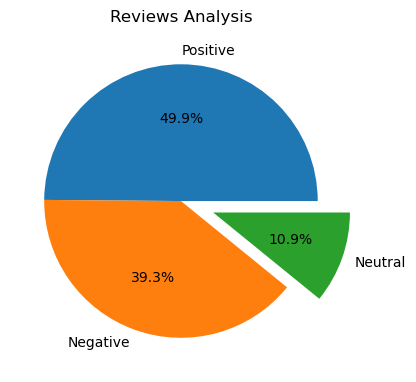

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,7))

plt.subplot(1,3,2)
plt.title("Reviews Analysis")
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)

In [24]:
df.to_csv("BA_reviews.csv")

# Wordcloud
Word Cloud or Tag Clouds is a visualization technique for texts that are natively used for visualizing the tags or keywords from the websites

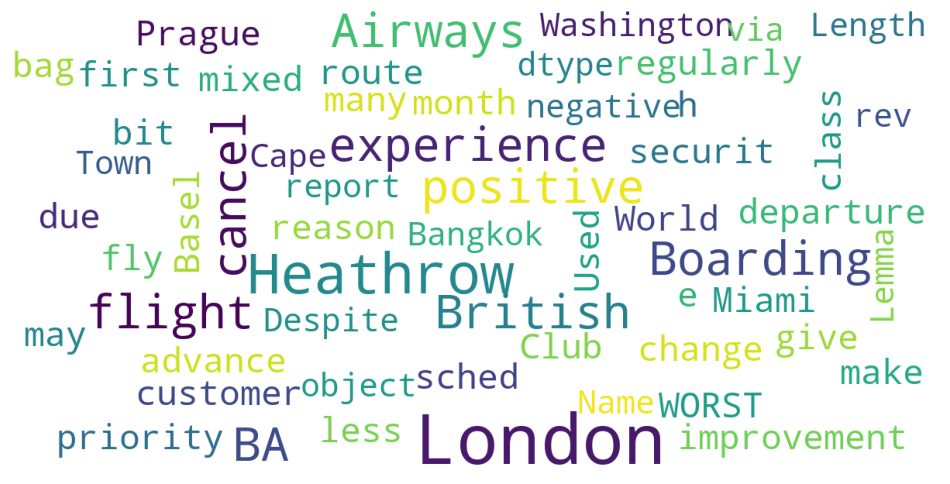

In [25]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df.Lemma)